In [1]:
from hybridbrep import BRepFaceAutoencoder, HPart, WeightedChamferDistance, GeneralConvEncDec
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
import os
from torch_geometric.transforms import SamplePoints
from torch_geometric.data import Data as TGData
import meshplot as mp
from chamferdist import ChamferDistance

Loading Model


100%|██████████| 300/300 [00:04<00:00, 64.33it/s]


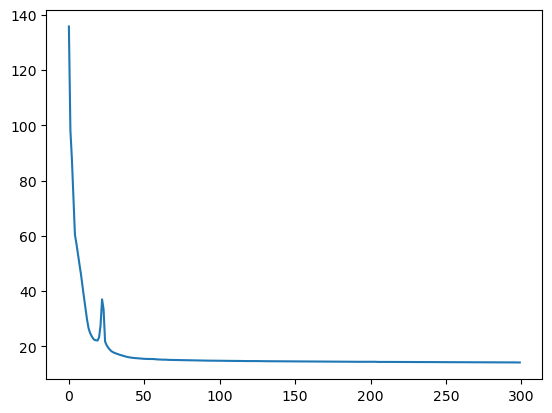

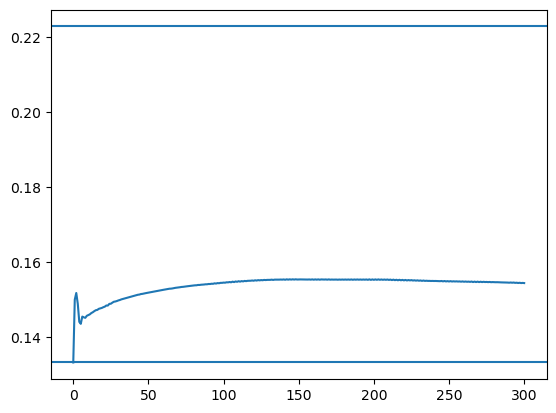

In [67]:
repbrep_path = '../../'
#model_checkpoint_path = '../../training_logs/reconstruction/old_no_loops/version_0/checkpoints/epoch=38-val_loss=0.002679.ckpt'

print('Loading Model')
ckpt_path = '/home/ben/Documents/research/repbrep/training_logs/reconstruction/new_with_edges/version_1/checkpoints/epoch=183-val_loss=0.002646.ckpt'
ckpt = torch.load(ckpt_path)
model = GeneralConvEncDec(64, 1024, 4)
model.load_state_dict(ckpt['state_dict'])

cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'cube.x_t')
angled_cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'angled_cube.x_t')
long_cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'long_cube.x_t')

frame_guide_1_path = os.path.join(repbrep_path, 'datasets', 'frame_guide', 'fg1.x_t')
frame_guide_2_path = os.path.join(repbrep_path, 'datasets', 'frame_guide', 'fg2.x_t')

rounded_rect_1_path = os.path.join(repbrep_path, 'datasets', 'rounded_rect', 'rounded_rect1.step')
rounded_rect_2_path = os.path.join(repbrep_path, 'datasets', 'rounded_rect', 'rounded_rect2.step')

holybox1_path = os.path.join(repbrep_path, 'datasets', 'holybox', 'holey_box.step')
holybox2_path = os.path.join(repbrep_path, 'datasets', 'holybox', 'holey_box_angled.step')

source_part_path = holybox1_path
target_part_path = holybox2_path

weighted = False#True
num_iters = 300
reproject = False

sampler = SamplePoints(6*1000)

source_part_bak = HPart(source_part_path, normalize=True).data
source_part = HPart(source_part_path, normalize=True).data
target_part = HPart(target_part_path, normalize=False).data
target_part_normalized = HPart(target_part_path, normalize=True).data

target_V = source_part.scale*(target_part.V + source_part.translation)
target_F = target_part.F
target_data = TGData(pos=target_V,face=target_F)
sampler(target_data)
target_pc = target_data.pos

#checkpoint = torch.load(model_checkpoint_path)

#model = BRepFaceAutoencoder(64, 1024,4, False)
#model.load_state_dict(checkpoint['state_dict'])

n_faces = len(source_part.faces)
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
grids = grids.reshape((n_faces,-1,2))
#indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)

model = model.cuda()
grids = grids.cuda()
#indices = indices.cuda()
target = target_pc.unsqueeze(0).float().cuda()
source_part = source_part.cuda()

source_part.faces.requires_grad = True
source_part.edges.requires_grad = True
source_part.vertices.requires_grad = True

opt = torch.optim.SGD(
    [
        source_part.faces,
        source_part.edges,
        source_part.vertices
    ], 
    lr=0.00075, 
    momentum=0.3
)

losses = []
predictions = []
chamferDist = WeightedChamferDistance(sharpness=2) if weighted else ChamferDistance()

radii = []
for iter in tqdm(range(num_iters)):
    radii.append(source_part.faces[0,17].detach().item())

    opt.zero_grad()
    _, pred = model(source_part, grids)#, indices)
    pred_xyz = pred[:,:3].unsqueeze(0).float()
    pred_m = pred[:,3].unsqueeze(0).float()
    loss = chamferDist(pred.unsqueeze(0).float(), target) if weighted else chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    predictions.append((pred_xyz.detach().cpu().numpy(), pred_m.detach().cpu().numpy()))
radii.append(source_part.faces[0,17].detach().item())

plt.plot(losses)
plt.figure()
plt.plot(radii)
plt.axhline(y=source_part_bak.faces[0,17])
plt.axhline(y=target_part_normalized.faces[0,17])

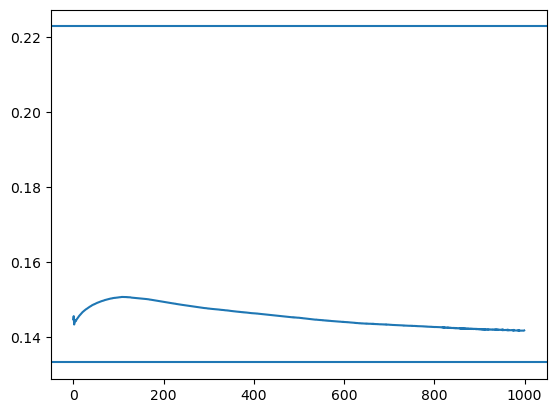

In [48]:
n_plots = 10
n_preds = len(predictions)
plot_steps = torch.linspace(0,n_preds-1,n_plots).int().numpy()

for i in plot_steps:
    xyz = predictions[i][0][0,:,:]
    mask = predictions[i][1][0,:]

    plot = mp.plot(xyz, c=(mask <= 0.0), shading={'point_size':0.1}, return_plot=True)
    plot.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0088132…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.063395…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.120200…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.136508…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.141267…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.146030…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.149101…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.153067…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.149200…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.156473…

In [38]:
source_part.faces[:,:5].argmax(dim=1)

tensor([1, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [39]:
source_part.faces.shape

torch.Size([7, 21])

In [55]:
type = source_part.faces[:,:5].argmax(dim=1).detach().cpu().numpy()
origin = source_part.faces[:,5:8].cpu().detach().numpy()
normal = source_part.faces[:,8:11].cpu().detach().numpy()
axis = source_part.faces[:,11:14].cpu().detach().numpy()
ref_dir = source_part.faces[:,14:17].cpu().detach().numpy()
radius = source_part.faces[:,17].cpu().detach().numpy()
minor_radius = source_part.faces[:,18].cpu().detach().numpy()
semi_angle = source_part.faces[:,19].cpu().detach().numpy()
flipped = target_part.faces[:,20].cpu().detach().numpy()

In [63]:
target_part_normalized.faces[0,17]

tensor(0.2228)

In [59]:
source_part_bak.faces[0,14:17]

tensor([1., 0., 0.])

In [60]:
ref_dir[0]

array([ 1.0085293 ,  0.01936116, -0.02645118], dtype=float32)

In [58]:
(ref_dir[0]**2).sum()

1.0182059

In [42]:
plane_num = 1
for i in range(len(type)):
    p_x, p_y, p_z = origin[i].tolist()
    flip = flipped[i]*2 - 1
    n_x, n_y, n_z = (flip*normal[i]).tolist()
    a_x, a_y, a_z = (flip*axis[i]).tolist()
    r = radius[i]
    if type[i] == 0:
        print(f'{plane_num} Plane( point=({p_x:.4f}, {p_y:.4f}, {p_z:.4f}), normal=({n_x:.4f}, {n_y:.4f}, {n_z:.4f}))\n')
        plane_num += 1
    else:
        print(f'Cylinder(origin=({p_x:.4f}, {p_y:.4f}, {p_z:.4f}), axis=({a_x:.4f}, {a_y:.4f}, {a_z:.4f}), radius={(r):.4f})\n')

Cylinder(origin=(0.3239, -0.0045, -0.0018), axis=(0.0152, -1.0423, 0.0031), radius=0.1509)

1 Plane( point=(1.0012, -0.0028, 0.0049), normal=(0.9491, 0.0239, 0.0024))

2 Plane( point=(0.0062, 0.0109, 0.6582), normal=(-0.0217, -0.0142, 0.9606))

3 Plane( point=(-1.0073, -0.0028, -0.0102), normal=(-0.9675, -0.1803, -0.0662))

4 Plane( point=(-0.0007, 0.0075, -0.6735), normal=(-0.0185, 0.0289, -0.9523))

5 Plane( point=(0.0041, 0.2719, -0.0009), normal=(0.0410, 0.9908, -0.0307))

6 Plane( point=(-0.0001, -0.2769, -0.0004), normal=(0.0103, -1.0300, 0.0483))



In [43]:
plane_idx = 0
for i in range(len(type)):
    ori = origin[i].tolist()
    norm = normal[i].tolist()
    ax = axis[i].tolist()
    rad = radius[i]
    if type[i] == 0:
        print(f'Plane {plane_idx}( origin=({ori[0]:.4f}, {ori[1]:.4f}, {ori[2]:.4f}), normal=({norm[0]:.4f}, {norm[1]:.4f}, {norm[2]:.4f}))\n')
    elif type[i] == 1:
        print(f'Cylinder( origin=({ori[0]:.4f}, {ori[1]:.4f}, {ori[2]:.4f}), axis=({ax[0]:.4f}, {ax[1]:.4f}, {ax[2]:.4f}), radius={rad:.4f})\n')

Cylinder( origin=(0.3239, -0.0045, -0.0018), axis=(-0.0152, 1.0423, -0.0031), radius=0.1509)

Plane 0( origin=(1.0012, -0.0028, 0.0049), normal=(0.9491, 0.0239, 0.0024))

Plane 0( origin=(0.0062, 0.0109, 0.6582), normal=(-0.0217, -0.0142, 0.9606))

Plane 0( origin=(-1.0073, -0.0028, -0.0102), normal=(-0.9675, -0.1803, -0.0662))

Plane 0( origin=(-0.0007, 0.0075, -0.6735), normal=(-0.0185, 0.0289, -0.9523))

Plane 0( origin=(0.0041, 0.2719, -0.0009), normal=(0.0410, 0.9908, -0.0307))

Plane 0( origin=(-0.0001, -0.2769, -0.0004), normal=(-0.0103, 1.0300, -0.0483))



In [8]:
mp.plot(source_part.V.numpy(), source_part.F.T.numpy())

mp.plot(target_V.numpy(), target_F.T.numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.196962…